In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.sparse.linalg import norm

In [2]:
import sys
sys.path.insert(0, "../scripts")

from SZFW_lasso import *
from DZFW_lasso import *
from IZFW_lasso import *

## Load data

In [3]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [18]:
def CreateDataSet(n, d, s):
    """
    n rows, d features, s sparsity level
    """
    np.random.seed(1007)
    s = np.int(d * s)
    X = np.random.randn(n,d) 
    pn = int(s/2)
    w_s = np.concatenate((np.ones(pn), -np.ones(pn), np.zeros(d-2*pn)))
    w_s = w_s/np.sum(np.abs(w_s))
    epsilon = 0.01*np.random.rand(n) # noise
    y = X @ w_s + epsilon
    return X, y, w_s, epsilon

In [19]:
X, y, w_star, noise = CreateDataSet(n = 1000, d = 10000, s = 0.05)

In [12]:
np.sum(np.abs(w_star))

1.0000000000000004

In [13]:
# space dimension
d = X.shape[1]
n = y.shape[0]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 10000
n: 1000


In [14]:
# define the objective function
F = lambda w: 0.5/n * np.sum(np.power(y - X @ w, 2))

In [15]:
F(w_star)

1.6672240155384503e-05

In [25]:
# initialize prarameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

indeces = np.random.randint(low = 0, high = d-1, size = 20)
w0[indeces] = int(0)
w0 = np.zeros(d)
print(f"w0: {w0}")

w0: [0. 0. 0. ... 0. 0. 0.]


## Deterministic Gradient Free Frank Wolfe

In [ ]:
%%time

# Lipschitz constant 
L = 3

fpred, f, w, mean, t, loss, f_values = detZFW(F, L, d, w0, T=100)

In [ ]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

In [ ]:
lossd = np.load("../Data/results/loss_dZFW_lasso.npy") # data from colab (NOT NORMALIZED)
f_d = np.load("../Data/results/function_dZFW_lasso.npy")
f_d = f_d/n
f_star = np.min(f_d)

In [ ]:
F_eval = np.abs(f_d - f_star)
plt.plot(F_eval)
plt.yscale("log")
plt.title("dZFW")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

## Stochastic Gradient Free Frank Wolfe

In [30]:
%%time
fpred, f, w, mean, t, loss, f_values = stochasticZFW(F, d, w0, method = "IRDSA", r=1, T=10, eps=1e-10)

Loss evaluation at time 1:	0.0246347

Loss evaluation at time 2:	0.0242958

Loss evaluation at time 3:	0.0210544

Loss evaluation at time 4:	0.0081856

Loss evaluation at time 5:	0.0039112

Loss evaluation at time 6:	0.0170652

Loss evaluation at time 7:	0.0094145

Loss evaluation at time 8:	0.0093013

Loss evaluation at time 9:	0.0066842

Loss evaluation at time 10:	0.0057219

CPU times: user 1min 37s, sys: 5.23 s, total: 1min 42s
Wall time: 27.8 s


In [31]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.0010340795040677865

F(w_pred) = 0.010661740927335196

F(w) = 0.016383607814956107

w = [0. 0. 0. ... 0. 0. 0.]

average w = [0. 0. 0. ... 0. 0. 0.]

T = 10


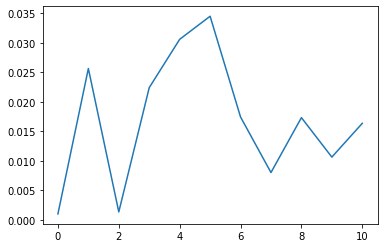

In [32]:
plt.plot(f_values - F(w_star))

In [ ]:
f_values

In [ ]:
loss_stochm6 = np.load("../Data/results/loss_SZFWm6_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm6 = np.load("../Data/results/function_SZFWm6_lasso.npy")
f_stochm6 = f_stochm6/n

In [ ]:
F_eval = np.abs(f_stochm6 - f_star)
plt.plot(F_eval)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6)")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

In [ ]:
loss_stochm1 = np.load("../Data/results/loss_SZFWm1_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm1 = np.load("../Data/results/function_SZFWm1_lasso.npy")
f_stochm1 = f_stochm1/n

In [ ]:
F_eval = np.abs(f_stochm6 - f_star)
plt.plot(F_eval)
plt.yscale("log")
plt.title("sZFW with RDSA (m=1)")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

## Zeroth order stochastic accelerated gradient method with Inexact updates

In [31]:
%%time 

# setting parameters
L = 0.1
D = 10000 # we will start from m = 6, up to T * (T+1) / D * (d+3) = 28785 (for T=100)
B = 1

fpred, f, w, mean, t, loss, f_values = IZFW(F, d, w0, L, B, r = 1, T = 10, eps = 1e-3)

Loss evaluation at time 1:	1.3791321

Loss evaluation at time 2:	0.4522815



KeyboardInterrupt: 

In [33]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 259.05091757836703

F(w) = 259.0508674789056

w = [2.59069832e-12 3.76718696e-12 2.88669335e-14 ... 2.71115010e-12
 3.13978697e-13 1.17696342e-12]

average w = [3.24063977e-09 4.71227999e-09 3.61089254e-11 ... 3.39130988e-09
 3.92748103e-10 1.47223411e-09]

T = 10000


In [ ]:
f_inex = np.load('../Data/results/function_IZFW_lasso.npy') # data from cluster
F_eval = np.abs(f_inex/n - f_star)
plt.plot(F_eval)
plt.yscale("log")
plt.title("IZFW with m(t) < n")
plt.grid()

In [ ]:
F_eval = np.abs(f_inex/n - np.min(f_inex/n))
plt.plot(F_eval)
plt.yscale("log")
plt.title("IZFW with m(t) < n")
plt.grid()